# Assignment 1: detecting offensive content on twitter
**Assignment due 1 March 2025 11:59pm**

Welcome to the first assignment for 50.055 Machine Learning Operations. These assignments give you a chance to practice the methods and tools you have learned. 

**This assignment is an individual assignment.**

- Read the instructions in this notebook carefully
- Add your solution code and answers in the appropriate places. The questions are marked as **QUESTION:**, the places where you need to add your code and text answers are marked as **ADD YOUR SOLUTION HERE**
- The completed notebook, including your added code and generated output, will be your submission for the assignment.
- The notebook should execute without errors from start to finish when you select "Restart Kernel and Run All Cells..". Please test this before submission.
- Use the SUTD Education Cluster or Google Colab to solve and test the assignment.

**Rubric for assessment** 

Your submission will be graded using the following criteria. 
1. Code executes: your code should execute without errors. The SUTD Education cluster should be used to ensure the same execution environment.
2. Correctness: the code should produce the correct result or the text answer should state the factual correct answer.
3. Style: your code should be written in a way that is clean and efficient. Your text answers should be relevant, concise and easy to understand.
4. Partial marks will be awarded for partially correct solutions.
5. There is a maximum of 76 points for this assignment.


**ChatGPT policy:** 

If you use AI tools, such as ChatGPT, to solve the assignment questions, you need to be transparent about its use and mark AI-generated content as such. In particular, you should include the following in addition to your final answer:
- A copy or screenshot of the prompt you used
- The name of the AI model
- The AI generated output
- An explanation why the answer is correct or what you had to change to arrive at the correct answer

**Assignment Notes:** Please make sure to save the notebook as you go along. Submission Instructions are located at the bottom of the notebook.


In [1]:
# # Installing all required packages
# # ----------------
# ! pip install transformers[torch]==4.37.2
# ! pip install evaluate==0.4.1
# ! pip install scikit-learn==1.4.0
# ! pip install datasets==2.17.1
# ! pip install wandb==0.16.3
# ! pip install seaborn==0.13.2
# ! pip install peft==0.10.0
# ! pip install accelerate==0.28.0 
# # ----------------



In [2]:
# Importing all required packages
# ----------------
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn import metrics


import pandas as pd
import numpy as np
import evaluate
import time

import seaborn as sns
import matplotlib.pyplot as plt

import transformers
from transformers import AutoTokenizer
from transformers import TrainingArguments, Trainer
from datasets import load_dataset
# ----------------

/Users/jin/KC_game/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


https://www.geeksforgeeks.org/bar-plot-in-matplotlib/
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
https://stackoverflow.com/questions/22210768/getting-training-time-in-scikit
https://towardsdatascience.com/calculating-a-baseline-accuracy-for-a-classification-model-a4b342ceb88f/

In [3]:
%matplotlib inline


# Offensive language detection

Content moderation of offensive or hateful language is an important task on social media platforms. 
In this assignment, you will train a text classification models for detecting offensive language on twitter. You will run experiments with different models and evaluate their performance and costs.

We will use the TweetEval data set from Barbiert et al (2020): https://aclanthology.org/2020.findings-emnlp.148.pdf


**Warning**
Some of the content contains rude and offensive language. If you know that this causes you distress, let the course instructor know to arrange a different assessment.




In [5]:
# load data set 
dataset = load_dataset("tweet_eval", "offensive")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 11916
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 860
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1324
    })
})

In [6]:
# QUESTION: print the first training set sample 

#--- ADD YOUR SOLUTION HERE (1 point)---

dataset.column_names

print(dataset['train'][0])

#------------------------------
# Hint: you should see a tweet about U2 singer Bono

{'text': '@user Bono... who cares. Soon people will understand that they gain nothing from following a phony celebrity. Become a Leader of your people instead or help and support your fellow countrymen.', 'label': 0}


In [7]:
# QUESTION: what are the possible values of the labels? What is their meaning? 
# Print the set of label values and their label names
#--- ADD YOUR SOLUTION HERE (5 points) ---
label_set = dataset['train'].unique('label')
print(f"ANSWER: The possible training values are: {label_set} \n")

training_dataset = dataset['train']
training_df = training_dataset.to_pandas()
label_1_mask = training_df['label'].isin([1])
label_0_mask = training_df['label'].isin([0])

label_1_sample = training_df[label_1_mask]['text'].head().to_list()
label_0_sample = training_df[label_0_mask]['text'].head().to_list()

print("This is the sample data for texts with label 1:")
for text in label_1_sample:
    print(text)
print("\n")


print("This is the sample data for texts with label 0:")
for text in label_0_sample:
    print(text)
print("\n")

print("ANSWER: By analyzing the sample data for data with label 0 and data with label 1, along with the given context that the data consists of rude and offensive language, we can determine text with label value 1 are 'offensive', while text with label value 0 are 'not offensive'. ")
# -------
# Hint: it is a binary task

ANSWER: The possible training values are: [0, 1] 

This is the sample data for texts with label 1:
@user Eight years the republicans denied obama’s picks. Breitbarters outrage is as phony as their fake president.
@user She has become a parody unto herself? She has certainly taken some heat for being such an....well idiot. Could be optic too  Who know with Liberals  They're all optics.  No substance
@user Your looking more like a plant #maga #walkaway
@user Antifa would burn a Conservatives house down and CNN would be there lighting the torches &amp; throwing gas on the flames.
@user They cite Jones being banned for violating Twitter's ToS. There are blue checkmarks spewing the same, if not worse, kind of shit. If you are going to play the anyone can get banned"" card. Shouldn't these people also receive bans and suspensions? #VerifiedHate""


This is the sample data for texts with label 0:
@user Bono... who cares. Soon people will understand that they gain nothing from following a phon

Text(0.5, 0, 'Label count for training dataset')

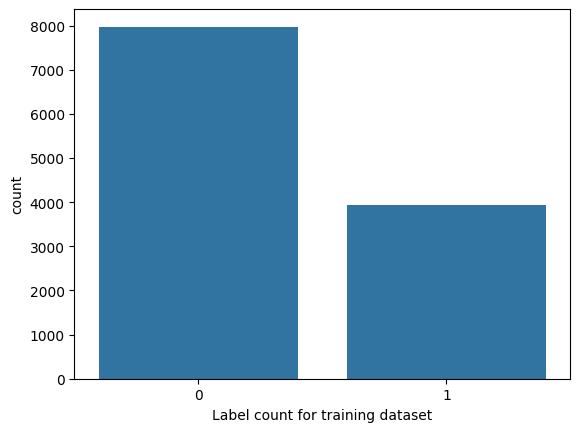

In [8]:
# QUESTION: plot a bar chart of the label distribution
#--- ADD YOUR SOLUTION HERE (5 points) ---
sns.countplot(x=dataset['train']['label'])
plt.xlabel('Label count for training dataset')

#------------------------------
# Hint: it is not evenly distributed

In [9]:
# QUESTION: separate data set into training, validation and test according to given dataset split
# You should end up with the following variables
# train_text = array containing strings in training set
# train_labels = array containing numeric labels in training set
# validation_text = array containing strings in training set
# validation_labels = array containing numeric labels in training set
# test_text = array containing strings in training set
# test_labels = array containing numeric labels in training set

#--- ADD YOUR SOLUTION HERE (10 points) ---

train_text = dataset['train']['text']
train_labels = dataset['train']['label']

validation_text = dataset['validation']['text']
validation_labels = dataset['validation']['label']

test_text = dataset['test']['text']
test_labels = dataset['test']['label']

#------------------------------


In [10]:
# check the size of the data splits
print("#train: ", len(train_text)) 
print("#validation: ", len(validation_text)) 
print("#test: ", len(test_text)) 

# Hint: you should see
#train:  11916
#validation:  1324
#test:  860

#train:  11916
#validation:  1324
#test:  860


In [11]:
# 
# QUESTION: create a scikit-learn pipeline object that creates unigram features, applies tf-idf weighting and trains a SGDClassifier 
# tf-idf stands for “Term Frequency times Inverse Document Frequency”.
# tf-idf is a feature weighting methods commonly used in NLP and IR
# use default parameters for unigram feature extraction, tf-idf and the SGDClassifier
# add additional import statements in this cell as needed

#--- ADD YOUR SOLUTION HERE (10 points) ---

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

pipeline = Pipeline([
    ('unigram', CountVectorizer()),
    ('tf-idf', TfidfTransformer()),  
    ('sgd', SGDClassifier())  
])

#------------------------------
# Hint: use the scikit-learn library

# Train the model


In [12]:
# 
# QUESTION: apply your pipeline of feature extraction and model training to the training set
# Measure the wall-clock training time needed 
# Store the training time in a variable 'train_time_sgd
#--- ADD YOUR SOLUTION HERE (5 points) ---

start_time = time.time()
pipeline.fit(X = train_text, y = train_labels)
pipeline.memory
end_time = time.time()

train_time_sgd = end_time-start_time
#------------------------------


In [13]:
print(f"Training time: {train_time_sgd}s")

# Hint: training should take < 1 sec

Training time: 0.19431018829345703s


# Test the model


In [14]:
# 
# QUESTION: compute the majority class baseline score on the validation set and test set
# the majority class baseline is the score you get if you always predict the most frequent label
# 
# Compute the precision, recall and F1 score for the majority baseline for validation and test set for each class
#
#--- ADD YOUR SOLUTION HERE (5 points) ---

from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_majority_baseline(data_labels: list) -> tuple[float, list]:
    label1 = data_labels.count(1)
    label0 = data_labels.count(0)
    total_labels = len(data_labels)

    if label1 > label0:
        return label1/total_labels, [1]*total_labels
    else:
        return label0/total_labels, [0]*total_labels


val_majority_baseline_score, val_majority_baseline_prediction = calculate_majority_baseline(validation_labels)
test_majority_baseline_score, test_majority_baseline_prediction = calculate_majority_baseline(test_labels)

print(f"The majority baseline score of validation set and test set are {val_majority_baseline_score} and {test_majority_baseline_score} respectively. \n")

val_precision = precision_score(y_true=validation_labels, y_pred=val_majority_baseline_prediction, average= None, labels=[0,1], zero_division=0)
val_recall = recall_score(y_true=validation_labels, y_pred=val_majority_baseline_prediction, average= None, labels=[0,1], zero_division=0)
val_f1 = f1_score(y_true=validation_labels, y_pred=val_majority_baseline_prediction, average= None, labels=[0,1], zero_division=0)

test_precision = precision_score(y_true=test_labels, y_pred=test_majority_baseline_prediction, average= None, labels=[0,1], zero_division=0)
test_recall = recall_score(y_true=test_labels, y_pred=test_majority_baseline_prediction, average= None, labels=[0,1], zero_division=0)
test_f1 = f1_score(y_true=test_labels, y_pred=test_majority_baseline_prediction, average= None, labels=[0,1], zero_division=0)

for idx in range(len(test_precision)):
    print(f"The precision for the test dataset for the class with label {idx} is: {test_precision[idx]}")
    print(f"The recall for the test dataset for the class with label {idx} is: {test_recall[idx]}")
    print(f"The f1 score for the test dataset for the class with label {idx} is: {test_f1[idx]}\n")

for idx in range(len(val_precision)):
    print(f"The precision for the validation dataset for the class with label {idx} is: {val_precision[idx]}")
    print(f"The recall for the validation dataset for the class with label {idx} is: {val_recall[idx]}")
    print(f"The f1 score for the validation dataset for the class with label {idx} is: {val_f1[idx]}\n")

#------------------------------


The majority baseline score of validation set and test set are 0.6533232628398792 and 0.7209302325581395 respectively. 

The precision for the test dataset for the class with label 0 is: 0.7209302325581395
The recall for the test dataset for the class with label 0 is: 1.0
The f1 score for the test dataset for the class with label 0 is: 0.8378378378378378

The precision for the test dataset for the class with label 1 is: 0.0
The recall for the test dataset for the class with label 1 is: 0.0
The f1 score for the test dataset for the class with label 1 is: 0.0

The precision for the validation dataset for the class with label 0 is: 0.6533232628398792
The recall for the validation dataset for the class with label 0 is: 1.0
The f1 score for the validation dataset for the class with label 0 is: 0.7903152124257652

The precision for the validation dataset for the class with label 1 is: 0.0
The recall for the validation dataset for the class with label 1 is: 0.0
The f1 score for the validation

In [15]:
# 
# 
# QUESTION: now use your pipeline to make predictions on validation and test set
# compute and print accuracy, precision, recall, F1 score
# 
# From now on, we are only concerned with the F1 score for the "positive" class which are the offensive tweets
# Store the test F1 score for the "positive" class in a variable 'f1_validation_sgd' and 'f1_test_sgd' for validation and test set, respectively 
#--- ADD YOUR SOLUTION HERE (10 points) ---
from sklearn.metrics import accuracy_score

val_pred = pipeline.predict(X = validation_text)
test_pred = pipeline.predict(X = test_text)

val_accuracy = accuracy_score(y_true=validation_labels, y_pred=val_pred)
val_precision = precision_score(y_true=validation_labels, y_pred=val_pred, zero_division=0)
val_recall = recall_score(y_true=validation_labels, y_pred=val_pred, zero_division=0)
f1_validation_sgd = f1_score(y_true=validation_labels, y_pred=val_pred, pos_label=1, zero_division=0)

print(f"The accuracy of the predictions for the validation dataset is: {val_accuracy}")
print(f"The precision of the predictions for the validation dataset is: {val_precision}")
print(f"The recall of the predictions for the validation dataset is: {val_recall}")
print(f"The f1 score of the predictions for the validation dataset for the 'positive' class is: {f1_validation_sgd}\n")

test_accuracy = accuracy_score(y_true=test_labels, y_pred=test_pred)
test_precision = precision_score(y_true=test_labels, y_pred=test_pred, zero_division=0)
test_recall = recall_score(y_true=test_labels, y_pred=test_pred, zero_division=0)
f1_test_sgd = f1_score(y_true=test_labels, y_pred=test_pred, pos_label=1, zero_division=0)

print(f"The accuracy of the predictions for the test dataset is: {test_accuracy}")
print(f"The precision of the predictions for the test dataset is: {test_precision}")
print(f"The recall of the predictions for the test dataset is: {test_recall}")
print(f"The f1 score of the predictions for the test dataset for the 'positive' class is: {f1_test_sgd}\n")

#------------------------------
# Hint: F1 scores should be >50%

The accuracy of the predictions for the validation dataset is: 0.7643504531722054
The precision of the predictions for the validation dataset is: 0.8154506437768241
The recall of the predictions for the validation dataset is: 0.4139433551198257
The f1 score of the predictions for the validation dataset for the 'positive' class is: 0.5491329479768786

The accuracy of the predictions for the test dataset is: 0.8011627906976744
The precision of the predictions for the test dataset is: 0.8
The recall of the predictions for the test dataset is: 0.38333333333333336
The f1 score of the predictions for the test dataset for the 'positive' class is: 0.5183098591549296



# BERT model

Now let us try a more powerful model: the DistilBERT uncased model

https://huggingface.co/distilbert-base-uncased

In [ ]:
# load DistilBERT tokenizer and tokenize data set
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["validation"]
test_dataset = tokenized_datasets["test"]

Map: 100%|██████████| 1324/1324 [00:00<00:00, 9838.72 examples/s] 


In [ ]:
# load DistilBERT model for classification
from transformers import AutoModelForSequenceClassification

#--- ADD YOUR SOLUTION HERE (5 points) ---
num_labels = len(np.unique(dataset['train']['label']))
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
#------------------------------
# Hint: make sure your model corresponds to your tokenizer

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# add custom metrics that computes precision, recall, f1, accuracy

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)

   # Calculate precision, recall, and F1-score
    precision = precision_score(labels, preds, average='binary')
    recall = recall_score(labels, preds, average='binary')
    f1 = f1_score(labels, preds, average='binary')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [ ]:

#
# QUESTION: configure the training parameters using the Huggingface TrainingArguments class
# - set the output directory to "finetuning-tweeteval"
# - do not report training metrics to an external experiment tracking service
# - print acc/p/r/f1 scores on the validation set every 200 steps
# - learning rate to 2e-5, 
# - set weight decay to 0.01
# - set epochs to 1


#--- ADD YOUR SOLUTION HERE (5 points) ---

training_args = TrainingArguments(
    output_dir="finetuning-tweeteval",
    evaluation_strategy="steps",
    learning_rate=2e-5,
    weight_decay=0.01,
    num_train_epochs=1,
    logging_steps=200)

#------------------------------



/Users/jin/KC_game/venv/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
# train the model
train_output = trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | f

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,0.546200,0.559592,0.719033,0.564829,0.825708,0.670796
400,0.486100,0.455266,0.794562,0.771014,0.579521,0.661692
600,0.466600,0.447655,0.791541,0.710345,0.673203,0.691275
800,0.431000,0.456578,0.799094,0.774929,0.592593,0.671605
1000,0.448200,0.445006,0.789275,0.763158,0.568627,0.651685
1200,0.452600,0.432451,0.796073,0.752000,0.614379,0.676259
1400,0.437500,0.428866,0.803625,0.726651,0.694989,0.710468


In [ ]:
# Evaluate on training set
trainer.evaluate(train_dataset)


{'eval_loss': 0.3610236942768097,
 'eval_accuracy': 0.8480194696206781,
 'eval_precision': 0.77734375,
 'eval_recall': 0.7574219741182441,
 'eval_f1': 0.7672535663796427,
 'eval_runtime': 236.2027,
 'eval_samples_per_second': 50.448,
 'eval_steps_per_second': 6.308,
 'epoch': 1.0}

In [ ]:
# Evaluate on validation set
trainer.evaluate(eval_dataset)

{'eval_loss': 0.42928385734558105,
 'eval_accuracy': 0.8021148036253777,
 'eval_precision': 0.7193763919821826,
 'eval_recall': 0.7037037037037037,
 'eval_f1': 0.711453744493392,
 'eval_runtime': 26.5726,
 'eval_samples_per_second': 49.826,
 'eval_steps_per_second': 6.247,
 'epoch': 1.0}

In [ ]:
# Evaluate on test set
test_output = trainer.evaluate(test_dataset)
for key in test_output:
    print(f"{key}: {test_output[key]}")


eval_loss: 0.3737415075302124
eval_accuracy: 0.8441860465116279
eval_precision: 0.7431192660550459
eval_recall: 0.675
eval_f1: 0.7074235807860262
eval_runtime: 17.186
eval_samples_per_second: 50.041
eval_steps_per_second: 6.284
epoch: 1.0


### QUESTION: 
Do you see any signs of overfitting or underfitting based on the evaluation scores
Explain why or why not

**--- ADD YOUR SOLUTION HERE (5 points) ---**

There are no signs of overfitting or underfitting. Comparing the accuracy from all 3 evaluations, we find that the model's performance was somewhat close with just a ~4% difference in accuracy from the validation set and the training set. Next, comparing the model's loss on all 3 evaluations, we also find that the model's performance was roughly around 0.3 to 0.4, which is another sign that there is unlikely any sign of overfitting or underfitting of the model. Finally, the precision and recall of all 3 evaluation sets are very close. 

With these findings, we can conclude that there are no signs of overfitting or underfitting based on the evaluation scores.

------------------------------


In [ ]:
#
# QUESTION: What is the ratio f1 score to training time for the SGDClassifier and the DistilBERT model
# compute the two ratios and print them

#--- ADD YOUR SOLUTION HERE ---
train_time_bert = train_output.metrics["train_runtime"]
f1_test_bert = test_output['eval_f1']

ratio_sgd = f1_test_sgd/train_time_sgd
ratio_bert = f1_test_bert/train_time_bert

print(f"Ratio for SGD model: {ratio_sgd}")
print(f"Ratio for bert model: {ratio_bert}")
#------------------------------
print(f1_test_sgd, f1_test_bert)

Ratio for SGD model: 2.7669286009031966
Ratio for bert model: 0.0007723897457335199
0.5307262569832403 0.7074235807860262


### QUESTION: 
Given the results what model would you recommend to use? Write a paragraph (max 200 words) to explain your choice

**--- ADD YOUR SOLUTION HERE (10 points)---**

I would recommend to the BERT model. Given the context that this model is used to detect offensive language in posts, more emphasis should be placed on the true positive and false negatives of the model's performance. The reprecussions from falsely identifying an offensive post as "non offensive" is far more severe than falsely identifying a safe post as offensive as it could potentially lead to more dangerous behaviour. With that, the BERT model had a much higher F1 score than the sgd model, hence indicating that it is more capable of detecting offensive posts and hence I recommend it.

It should be noted that this answer assumes that there are adequete resources to train the BERT model. If training resources are very limited, it could be more beneficial to experiment with the SGD model.

------------------------------


# End

This concludes assignment 1.


Please submit this notebook with your answers and the generated output cells as a **Jupyter notebook file** via github.


1. Create a private github repository **sutd_5055mlop** under your github user.
2. Add your instructors as collaborator: ddahlmeier and lucainiaoge
3. Save your submission as assignment_01_STUDENT_NAME.ipynb where STUDENT_NAME is your name in your SUTD email address.
4. Push the submission file to your repo 
5. Submit the link to the repo via eDimensions

Example:<br/>
Email: michael_tan@mymail.sutd.edu.sg<br/>
STUDENT_NAME: michael_tan<br/>
Submission file name: assignment_01_michael_tan.ipynb



**Assignment due 01 March 2025 11:59pm**


